## Inicialización: dataset + dependencias


In [2]:
# install quitely
!pip install mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import mlflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import albumentations as A


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
!wget https://raw.githubusercontent.com/mf1024/ImageNet-Datasets-Downloader/master/downloader.py
!wget https://github.com/mf1024/ImageNet-Datasets-Downloader/raw/master/imagenet_class_info.json

--2024-11-01 18:01:52--  https://raw.githubusercontent.com/mf1024/ImageNet-Datasets-Downloader/master/downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10046 (9.8K) [text/plain]
Saving to: ‘downloader.py’

downloader.py       100%[===================>]   9.81K  --.-KB/s    in 0s      

2024-11-01 18:01:52 (24.0 MB/s) - ‘downloader.py’ saved [10046/10046]

--2024-11-01 18:01:52--  https://github.com/mf1024/ImageNet-Datasets-Downloader/raw/master/imagenet_class_info.json
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mf1024/ImageNet-Datasets-Downloader/master/imagenet_class_info.json 

In [5]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python downloader.py -data_root "/content/drive/MyDrive/" -number_of_classes 20  -images_per_class 100

Picked the following clases:
['pallone', 'wood warbler', 'grenade', 'golden oriole', 'addict', 'niqab', 'percolator', 'person', 'damask', 'tower', 'craftsman', 'meadow goldenrod', 'water buffalo', 'swallow-tailed kite', 'dwarf iris', 'rough', 'elapid', 'coral root', 'Carioca', 'peach orchard']
Scraping images for class "pallone"
Multiprocessing workers: 8
Scraping images for class "wood warbler"
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 161.0 successes
66.52892561983471% success rate for is_flickr urls 
0.15810748360912252 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 161.0 successes
66.52892561983471% success rate for all urls 
0.15810808780030436 seconds spent per all succesful image download
Process ForkPoolWorker-15:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-14:
Traceback (most recent 

##  EDA + augmentation


In [52]:
p_HF = 0.5
p_RBC = 0.1
transform = A.Compose([
    #A.RandomCrop(width=224, height=224),
    #A.HorizontalFlip(p=p_HF),
    A.RandomBrightnessContrast(p=p_RBC),
])


In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/imagenet_images",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=37,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/imagenet_images",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=37,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',

)

Found 176 files belonging to 2 classes.
Using 141 files for training.
Found 176 files belonging to 2 classes.
Using 35 files for validation.


In [12]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

In [9]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])

        ax.imshow(np.array(image[i],np.int32))  #Transformamos a np.int32 porque sino se veía mal
        ax.set_title(f"Label: {label[i]}")

In [13]:

ds_tf = train_ds.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

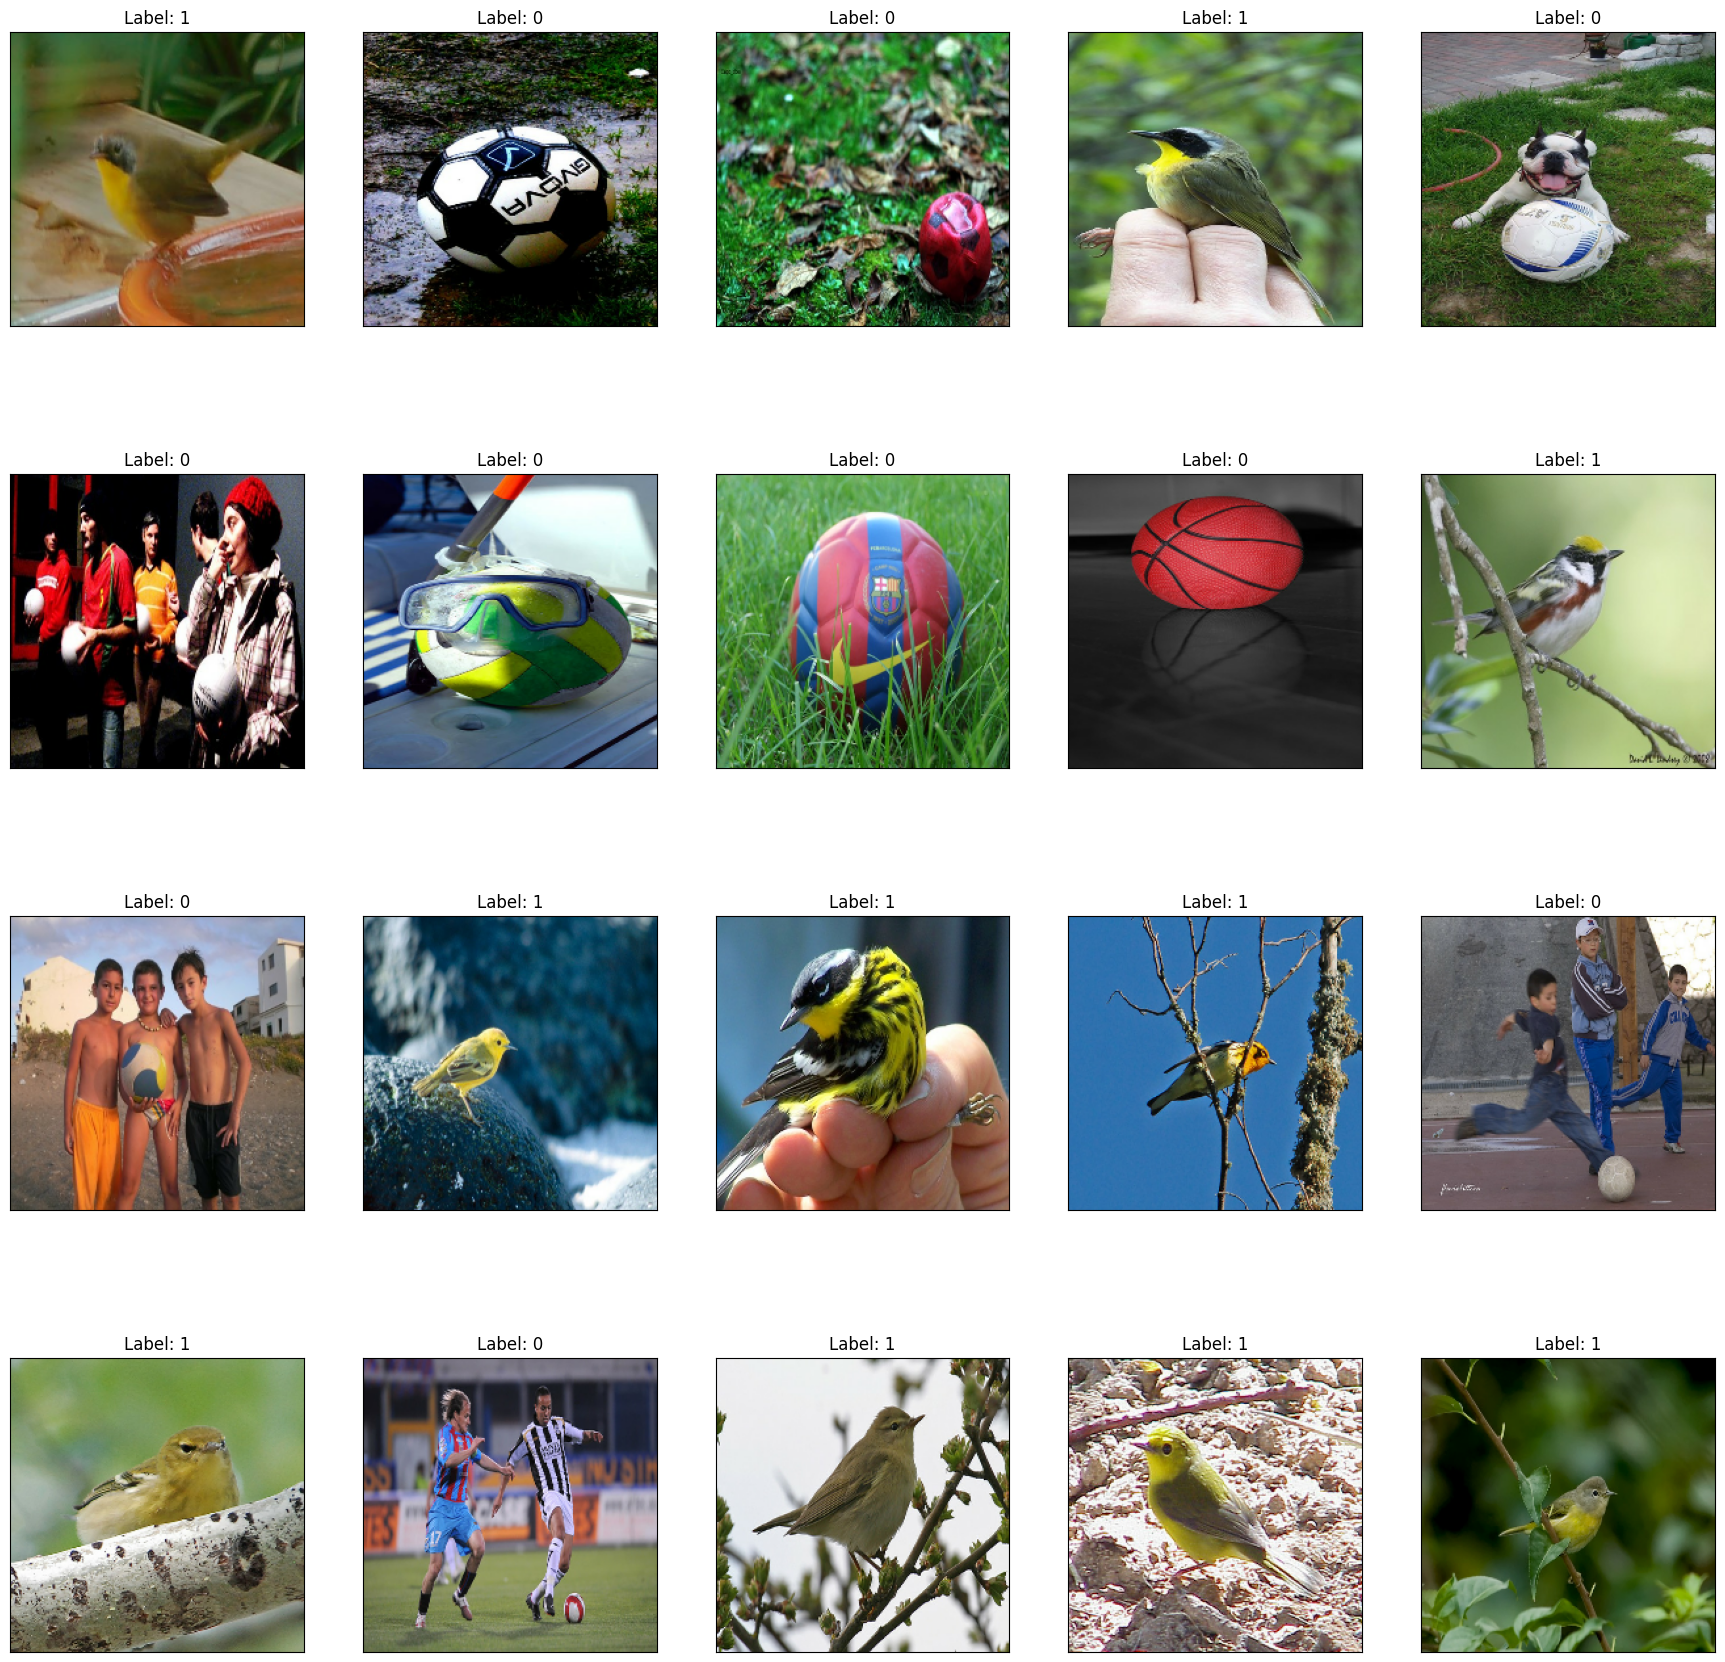

In [14]:
view_image(train_ds)

Basado en: https://albumentations.ai/docs/examples/tensorflow-example/

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [70]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0,tf.uint8)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [71]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [72]:
ds_alb = train_ds.map(partial(process_data, img_size=224), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Se ve todo negro y no sé por qué

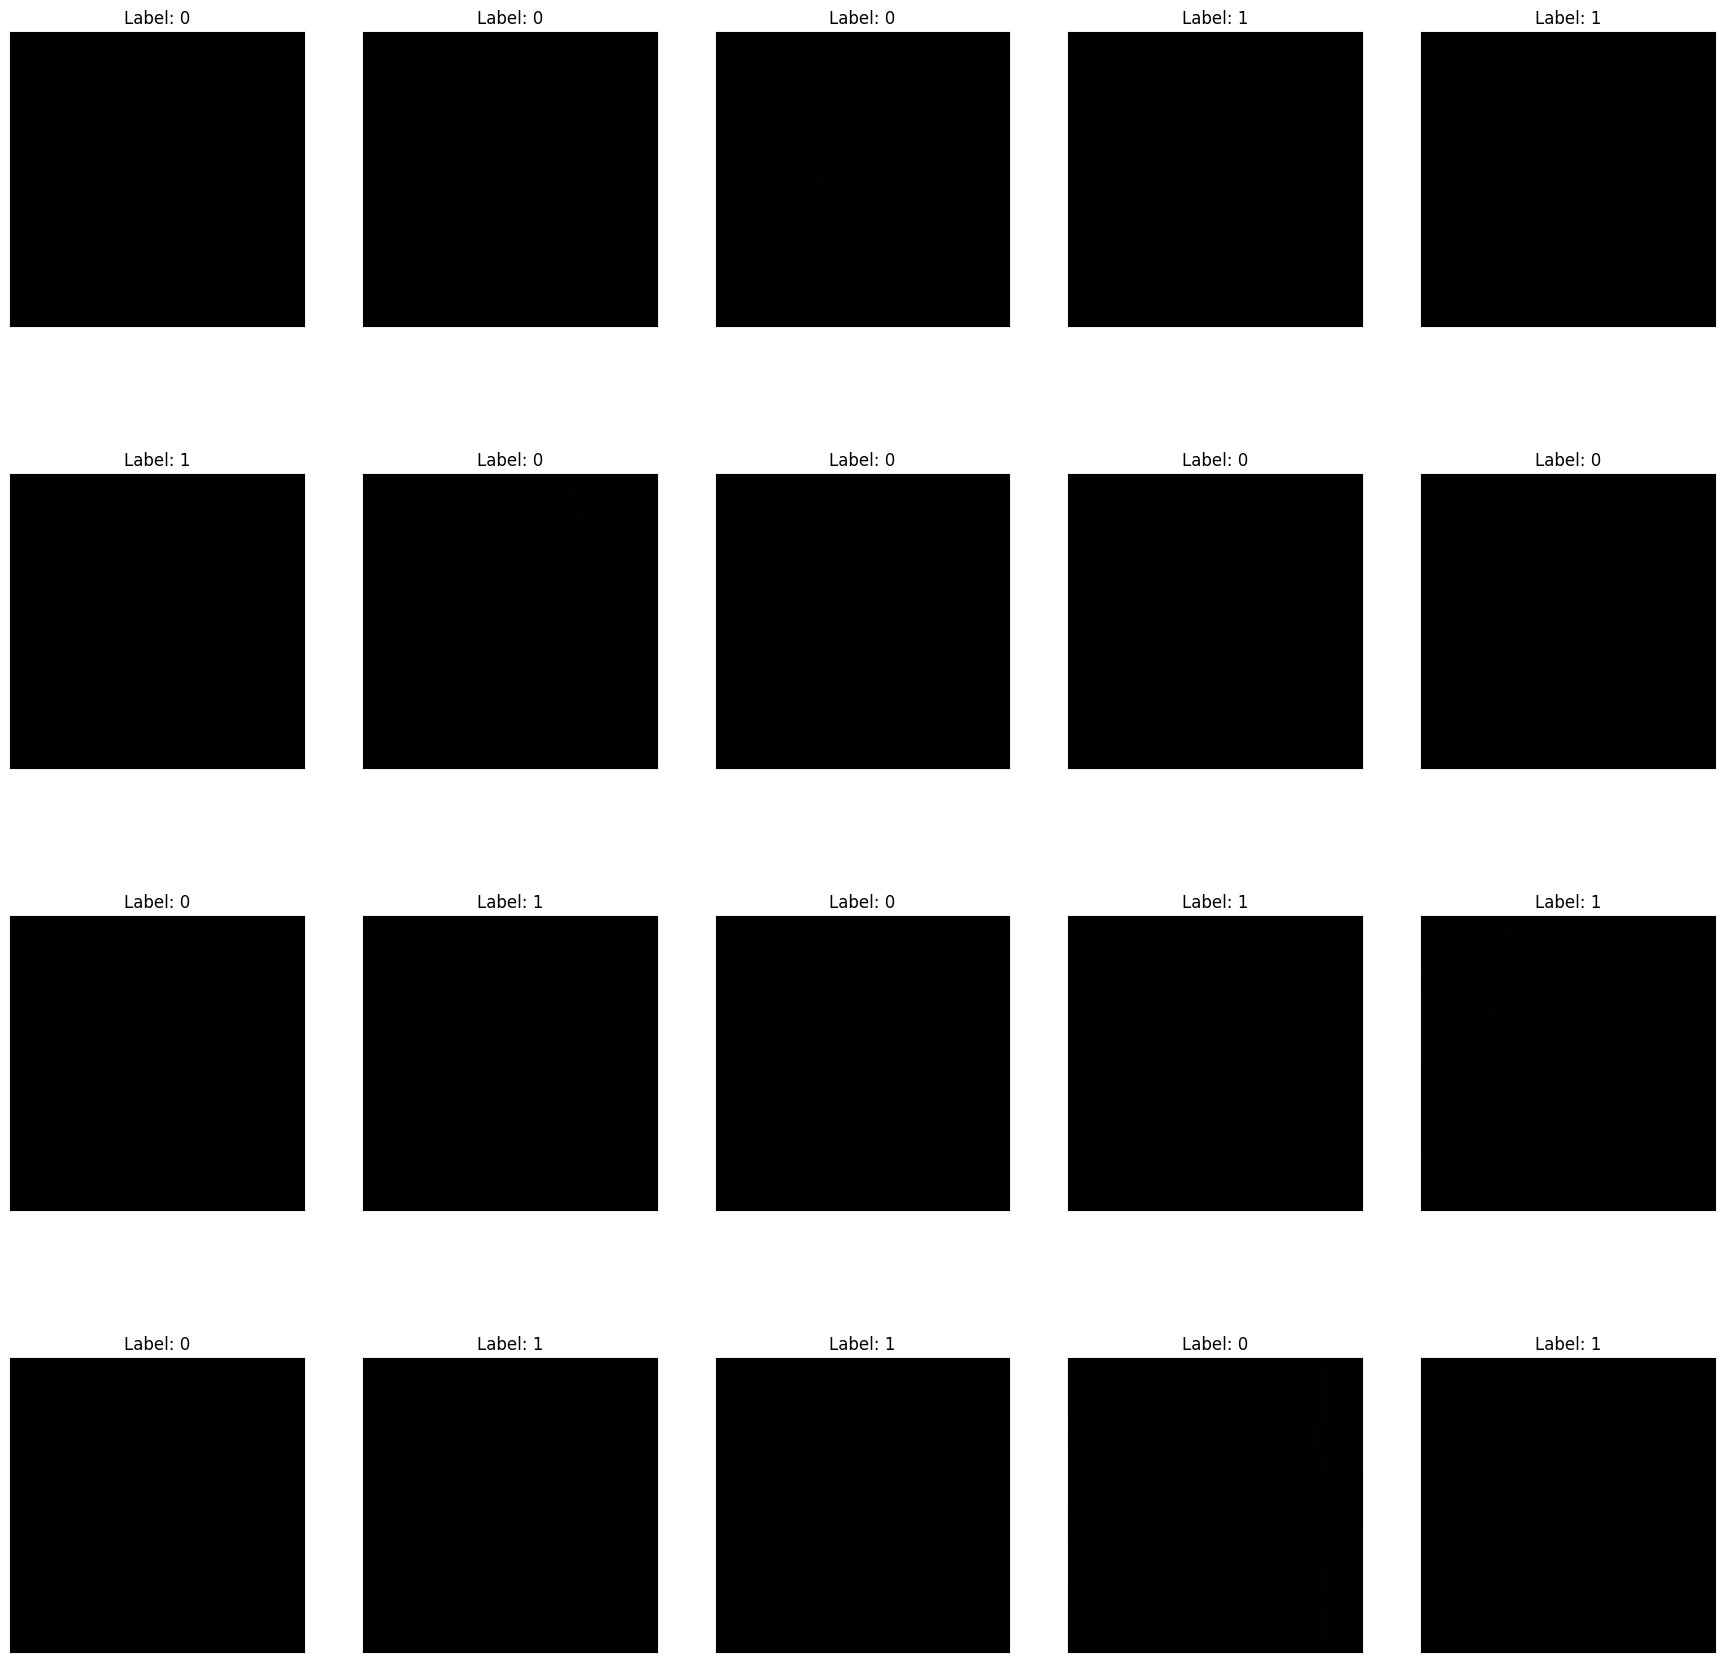

In [73]:
view_image(ds_alb)

In [67]:
def set_shapes(img, label, img_shape=(224,224,3)):
    img.set_shape(img_shape)
    label.set_shape([0])
    return img, label

In [68]:
ds_alb_1 = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb_1

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 0), dtype=tf.int32, name=None))>

y acá me tira este error

In [69]:
view_image(ds_alb_1)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [32,224,224,3] and element 4 had shape [13,224,224,3]. [Op:IteratorGetNext] name: 

## Modelo

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128,256]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0,0.1,0.5]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3, 1e-4]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [ ]:
def train_model(hparams):
    with mlflow.start_run():
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(hparams[HP_NUM_UNITS], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(hparams[HP_DROPOUT])(x)

        output_layer = Dense(20, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output_layer)

        for layer in base_model.layers:
            layer.trainable = False

        optimizer = Adam(learning_rate=hparams[HP_LEARNING_RATE])
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        tensorboard_callback = TensorBoard(log_dir="logs", histogram_freq=1)
        hparams_callback = hp.KerasCallback("logs/hparam_tuning", hparams)

        # Train model
        history = model.fit(
            ds_alb,
            validation_data=train_ds,
            epochs=2,
            callbacks=[tensorboard_callback, hparams_callback]
        )

        mlflow.log_param("num_units", hparams[HP_NUM_UNITS])
        mlflow.log_param("dropout", hparams[HP_DROPOUT])
        mlflow.log_param("learning_rate", hparams[HP_LEARNING_RATE])
        mlflow.log_metric("accuracy", max(history.history['accuracy']))

        mlflow.keras.log_model(model, "model")

In [ ]:
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for dropout in HP_DROPOUT.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout,
                HP_LEARNING_RATE: learning_rate,
            }
            print(f"--- Starting trial: {session_num+1}")
            print({h.name: hparams[h] for h in hparams})
            train_model(hparams)
            session_num += 1


--- Starting trial: 1
{'num_units': 64, 'dropout': 0.0, 'learning_rate': 0.0001}
Epoch 1/2


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 0), output.shape=(None, 20)